In [ ]:
# 구글 드라이브 Mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/AKI/mimic/3.0'

## 데이터 분석 목표

### 1. ICD-10: 진단명이 AKI로 되어 있는지

ICD-10(International Classification of Diseases, 10th Revision) 은 국제적으로 사용되는 질병 분류 코드 체계이며, 각 질병이나 상태는 고유한 코드로 분류되어 있습니다.

- ICD-10 분류에서 N17이 급성 신부전(Acute Kidney Injury, AKI)을 나타냅니다.

In [ ]:
import pandas as pd

# hosp 폴더에서 필요한 데이터 불러오기
diagnoses_icd_path = f'{path}/hosp/diagnoses_icd.csv.gz'
d_icd_diagnoses_path = f'{path}/hosp/d_icd_diagnoses.csv.gz'
labevents_path = f'{path}/hosp/labevents.csv.gz'

# 각 파일을 데이터프레임으로 불러오기
diagnoses_icd = pd.read_csv(diagnoses_icd_path)
d_icd_diagnoses = pd.read_csv(d_icd_diagnoses_path)

# 데이터 확인
print("diagnoses_icd 데이터 확인:")
print(diagnoses_icd.head())

print("\nd_icd_diagnoses 데이터 확인:")
print(d_icd_diagnoses.head())

diagnoses_icd 데이터 확인:
   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9

d_icd_diagnoses 데이터 확인:
  icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified
3     0020            9                          Typhoid fever
4     0021            9                    Paratyphoid fever A


MIMIC-IV 데이터셋에서는 다음과 같은 두 가지 버전의 ICD 코드를 사용합니다:

- ICD-9 (icd_version = 9): 주로 이전 진단에 사용된 코드 체계로, 숫자로만 구성된 코드.
- ICD-10 (icd_version = 10): 최근 진단에 사용된 코드 체계로, 문자와 숫자가 조합된 형태의 코드.

MIMIC-IV 데이터셋에서는 환자 입원 시기에 따라 ICD-9 또는 ICD-10 코드가 사용됩니다. 일반적으로 2015년 이전에 입원한 환자 데이터는 ICD-9, 이후에 입원한 환자 데이터는 ICD-10을 사용합니다.

=> 현재 불러온 diagnoses_icd 데이터에서는 ICD-9 코드만 포함되어 있으므로, 아마도 이 데이터는 2015년 이전의 진단 정보를 다루고 있는 것일 수 있습니다.

MIMIC-IV에서 AKI에 해당하는 ICD-9 코드는 다음과 같습니다:

- 5845: Acute kidney failure with lesion of tubular necrosis.
- 5846: Acute kidney failure with lesion of renal cortical necrosis.
- 5847: Acute kidney failure with lesion of renal medullary (papillary) necrosis.
- 5848: Acute kidney failure with other specified pathological lesion in kidney.
- 5849: Acute kidney failure, unspecified.

이 코드를 기반으로 AKI 환자를 필터링하고, labevents 데이터를 분석합니다.

In [ ]:
# 1. ICD-9 코드 기반으로 AKI 진단 코드 리스트 생성
aki_icd_9_codes = ['5845', '5846', '5847', '5848', '5849']

# 2. ICD-9 코드를 사용하여 AKI 관련 환자 필터링
aki_patients = diagnoses_icd[
    (diagnoses_icd['icd_code'].isin(aki_icd_9_codes)) &
    (diagnoses_icd['icd_version'] == 9)  # ICD-9 버전 확인
]

# AKI 환자 ID 목록 추출
aki_patient_ids = aki_patients['subject_id'].unique()

print(f"ICD-9 코드 기준 AKI 진단을 받은 환자 수: {len(aki_patient_ids)}명")

ICD-9 코드 기준 AKI 진단을 받은 환자 수: 20022명


In [ ]:
# 각 ICD-9 코드 당 환자 수 계산
aki_patient_count_per_code = aki_patients.groupby('icd_code')['subject_id'].nunique().reset_index()

# 컬럼명 변경
aki_patient_count_per_code.columns = ['icd_code', 'patient_count']

# 결과 출력
print("각 ICD-9 코드 당 고유 환자 수:")
print(aki_patient_count_per_code)

각 ICD-9 코드 당 고유 환자 수:
  icd_code  patient_count
0     5845           3031
1     5847              5
2     5848            116
3     5849          18220


- 5845: 세뇨관 괴사로 인한 급성 신부전 (3,031명)
  - 주로 신장에 독성이 있는 약물, 허혈(혈류 부족), 신체의 심각한 탈수 등
- 5847: 신수질 괴사로 인한 급성 신부전 (5명)
  - 주로 장기적인 요로 폐쇄, 진통제 과다 복용, 심각한 세균 감염 등
- 5848: 기타 특정 병리적 원인으로 인한 급성 신부전 (116명)
- 5849: 명확한 원인이 없는 급성 신부전 (18,220명)

#### AKI 환자의 성별

gender
M    11275
F     8747
Name: count, dtype: int64


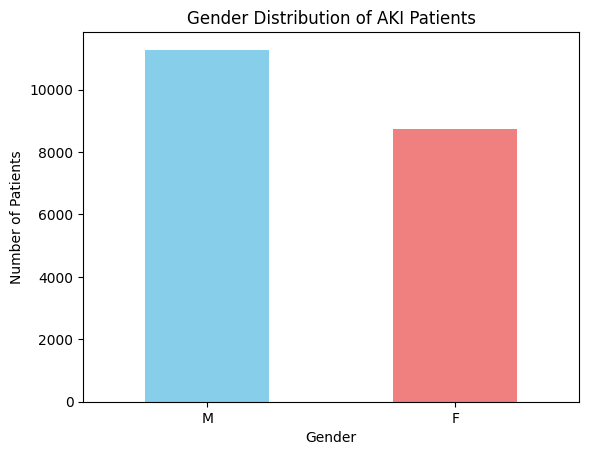

In [ ]:
patients_path =  f'{path}/hosp/patients.csv.gz'
patients = pd.read_csv(patients_path)

# AKI 환자 정보 추출
aki_patient_info = patients[patients['subject_id'].isin(aki_patient_ids)]

# 성별 분포 계산
gender_distribution = aki_patient_info['gender'].value_counts()
print(gender_distribution)

# 성별 분포 시각화
import matplotlib.pyplot as plt

gender_distribution.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Gender Distribution of AKI Patients')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

### 2. lab 데이터 종류에 뭐가 있는지

Lab 데이터는 병원에서 환자에게 시행된 각종 검사 결과를 의미합니다. 예를 들어, 혈액 검사, 소변 검사, 혈압 측정이 모두 여기에 포함됩니다.

In [ ]:
# RAM을 절약하기 위해 청크 사이즈를 설정합니다.
chunk_size = 1000000  # 100만 행 단위로 청크를 나눕니다.

# AKI 환자의 labevents 데이터를 저장할 리스트 초기화
filtered_labevents = []

# 청크 단위로 labevents 파일 읽기
for chunk in pd.read_csv(labevents_path, chunksize=chunk_size):
    # AKI 환자 데이터 필터링
    filtered_chunk = chunk[chunk['subject_id'].isin(aki_patient_ids)]
    filtered_labevents.append(filtered_chunk)
    print(f"청크 처리 완료, 현재 누적 행 수: {sum([len(chunk) for chunk in filtered_labevents])}")

# 필터링된 모든 청크를 하나의 데이터프레임으로 병합
aki_labevents = pd.concat(filtered_labevents, ignore_index=True)

# 결과 확인
print("필터링된 AKI 환자의 labevents 데이터:")
print(aki_labevents.head())

청크 처리 완료, 현재 누적 행 수: 257341
청크 처리 완료, 현재 누적 행 수: 465232


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

1. 데이터 컬럼 설명

labevents 데이터에는 실험실 검사 결과에 대한 다양한 정보가 포함되어 있습니다. 아래는 주요 컬럼의 설명입니다:

- labevent_id: 각 실험실 검사 이벤트의 고유 ID입니다.
- subject_id: 환자의 ID로, 해당 실험실 검사가 어떤 환자에게 수행되었는지를 나타냅니다.
- hadm_id: 입원 ID로, 환자가 입원 중인 동안 발생한 검사에 대한 정보입니다. NaN이면 해당 검사가 입원과 관련이 없음을 의미할 수 있습니다.
- specimen_id: 검사된 표본(샘플)의 ID입니다.
- itemid: 실험실 검사 항목의 ID로, 각 검사 항목을 고유하게 식별합니다. 예를 들어, 50912는 크레아티닌 검사입니다.
- order_provider_id: 검사를 주문한 의료 제공자의 ID입니다. NaN이면 이 정보가 기록되지 않았음을 의미합니다.
- charttime: 검사가 수행된 시간입니다.
- storetime: 검사의 결과가 데이터베이스에 저장된 시간입니다.
- value: 검사의 결과 값입니다. 예를 들어, 나트륨 농도가 140 mEq/L이면 이 값이 value 컬럼에 표시됩니다.
- valuenum: value 컬럼의 숫자 형태입니다. (동일한 정보를 숫자로 표현)
- valueuom: value의 단위입니다. 예를 들어, mEq/L, IU/L 등이 있습니다.
- ref_range_lower, ref_range_upper: 해당 검사 항목의 정상 하한 및 상한 값입니다. 예를 들어, 나트륨의 정상 범위는 135-145 mEq/L일 수 있습니다.
- flag: 비정상적인 검사 결과를 표시하는 플래그입니다. 비정상 결과일 경우 abnormal, 정상일 경우 NaN으로 표시됩니다.
- priority: 검사 결과의 우선순위입니다. 예를 들어, STAT는 긴급 검사를 의미합니다.
- comments: 검사 결과에 대한 추가적인 설명이나 코멘트입니다.

2. 분석

- 검사 항목 분포 분석:
  - 어떤 검사 항목이 가장 많이 수행되었는지 확인합니다.
  - 주요 검사 항목 (크레아티닌, 혈액 요소 질소(BUN) 등)별로 데이터 분포를 확인합니다.
- 환자별 검사 분석:
  - 환자별 검사 횟수 및 주요 검사 항목의 결과를 분석합니다.
  - 환자별로 비정상 결과의 비율을 분석합니다.
- 시계열 분석:
  - 특정 환자의 검사 결과가 시간에 따라 어떻게 변화했는지 시계열로 분석합니다.

In [ ]:
# 검사 항목별 수행 횟수 계산
item_counts = aki_labevents['itemid'].value_counts().reset_index()
item_counts.columns = ['itemid', 'count']

# 상위 10개 검사 항목 확인
print("상위 10개 검사 항목별 수행 횟수:")
print(item_counts.head(10))

상위 10개 검사 항목별 수행 횟수:
   itemid    count
0   50912  1111185
1   50971  1099162
2   51006  1091613
3   50983  1087546
4   50902  1080489
5   51221  1062627
6   50882  1042115
7   50868  1038929
8   51265  1022936
9   51222  1010467


In [ ]:
d_labitems_path = f'{path}/hosp/d_labitems.csv.gz'

lab_items = pd.read_csv(d_labitems_path)

# lab_items 데이터 구조 확인
print("실험실 검사 항목 데이터 확인:")
print(lab_items.head())

실험실 검사 항목 데이터 확인:
   itemid                                label  fluid   category
0   50801           Alveolar-arterial Gradient  Blood  Blood Gas
1   50802                          Base Excess  Blood  Blood Gas
2   50803  Calculated Bicarbonate, Whole Blood  Blood  Blood Gas
3   50804                 Calculated Total CO2  Blood  Blood Gas
4   50805                    Carboxyhemoglobin  Blood  Blood Gas


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

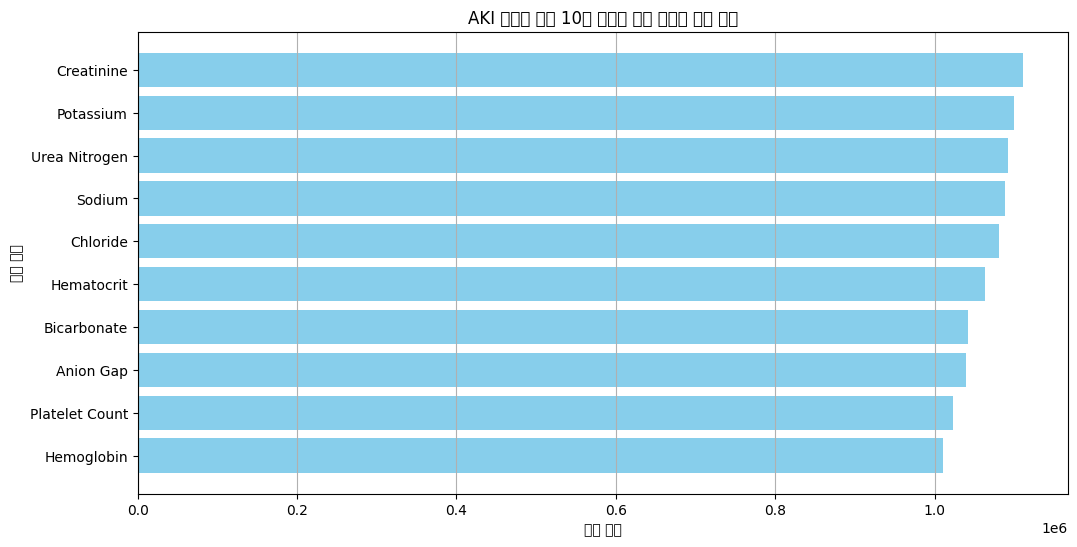

In [ ]:
import matplotlib.pyplot as plt

# 검사 항목 정보와 결합
item_counts = item_counts.merge(lab_items[['itemid', 'label']], on='itemid', how='left')

# 상위 10개 검사 항목만 선택
top_10_items = item_counts.head(10)

# 상위 10개 항목 수행 횟수 시각화
plt.figure(figsize=(12, 6))
plt.barh(top_10_items['label'], top_10_items['count'], color='skyblue')
plt.xlabel('수행 횟수')
plt.ylabel('검사 항목')
plt.title('AKI 환자의 상위 10개 실험실 검사 항목별 수행 횟수')
plt.gca().invert_yaxis()  # 큰 값이 위로 오도록 반전
plt.grid(axis='x')
plt.show()

| Item ID | 검사 항목명     | 수행 횟수  | 설명                                                |
|---------|-----------------|------------|-----------------------------------------------------|
| 50912   | Creatinine      | 1,111,185  | 신장 기능을 평가하기 위해 혈액에서 크레아티닌 수치를 측정하는 검사   |
| 50971   | Potassium       | 1,099,162  | 혈액 내 칼륨 수치를 측정하여 전해질 균형 및 심장 건강 상태를 평가     |
| 51006   | Urea Nitrogen   | 1,091,613  | 혈액 요소 질소(BUN)를 측정하여 신장 기능 및 대사 상태 평가           |
| 50983   | Sodium          | 1,087,546  | 혈액 내 나트륨 수치를 측정하여 체액 및 전해질 균형 상태 평가         |
| 50902   | Chloride        | 1,080,489  | 혈액 내 염화물 수치를 측정하여 산염기 균형 및 전해질 상태 평가       |
| 51221   | Hematocrit      | 1,062,627  | 혈액 내 적혈구의 비율을 측정하여 빈혈 및 탈수 상태를 평가           |
| 50882   | Bicarbonate     | 1,042,115  | 혈액 내 중탄산염 수치를 측정하여 산염기 균형 상태 평가             |
| 50868   | Anion Gap       | 1,038,929  | 음이온 차이를 계산하여 산염기 상태 이상 평가                       |
| 51265   | Platelet Count  | 1,022,936  | 혈액 내 혈소판 수치를 측정하여 응고 기능 및 혈액 질환 평가          |
| 51222   | Hemoglobin      | 1,010,467  | 혈액 내 헤모글로빈 수치를 측정하여 빈혈 상태를 평가               |


In [ ]:
# 상위 5% 검사 항목을 기준으로 주요 검사 항목 선정
top_percentile = item_counts['count'].quantile(0.95)
important_itemids = item_counts[item_counts['count'] >= top_percentile]

# 주요 검사 항목 정보 출력
print("선정된 주요 검사 항목 (상위 5% 기준):")
print(important_itemids[['itemid', 'label', 'count']])

선정된 주요 검사 항목 (상위 5% 기준):
    itemid                            label    count
0    50912                       Creatinine  1111185
1    50971                        Potassium  1099162
2    51006                    Urea Nitrogen  1091613
3    50983                           Sodium  1087546
4    50902                         Chloride  1080489
5    51221                       Hematocrit  1062627
6    50882                      Bicarbonate  1042115
7    50868                        Anion Gap  1038929
8    51265                   Platelet Count  1022936
9    51222                       Hemoglobin  1010467
10   51301                White Blood Cells  1004442
11   51249                             MCHC  1002844
12   51279                  Red Blood Cells  1002776
13   51248                              MCH  1002775
14   51250                              MCV  1002775
15   51277                              RDW  1002663
16   50931                          Glucose   943445
17   50893           

주요 검사 항목별 결과 통계 요약:
                              label        mean          std     min     25%  \
0                       Base Excess   -0.865579     6.698654 -413.00   -4.00   
1              Calculated Total CO2   25.415215     6.690504    0.00   21.00   
2                           Lactate    9.504117  3010.777567    0.00    1.20   
3                              pCO2   42.957732    12.468362    0.00   35.00   
4                                pH    7.365955     0.096444    1.32    7.32   
5                               pO2  118.572092    79.847962  -32.00   71.00   
6    Alanine Aminotransferase (ALT)   68.328513   285.848777    0.00   16.00   
7                           Albumin    3.609722     0.743810    0.70    3.10   
8              Alkaline Phosphatase  141.004422   146.922157    1.00   72.00   
9                         Anion Gap   14.396954     3.648846  -22.00   12.00   
10  Asparate Aminotransferase (AST)   85.561144   479.763648    0.00   20.00   
11                  

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

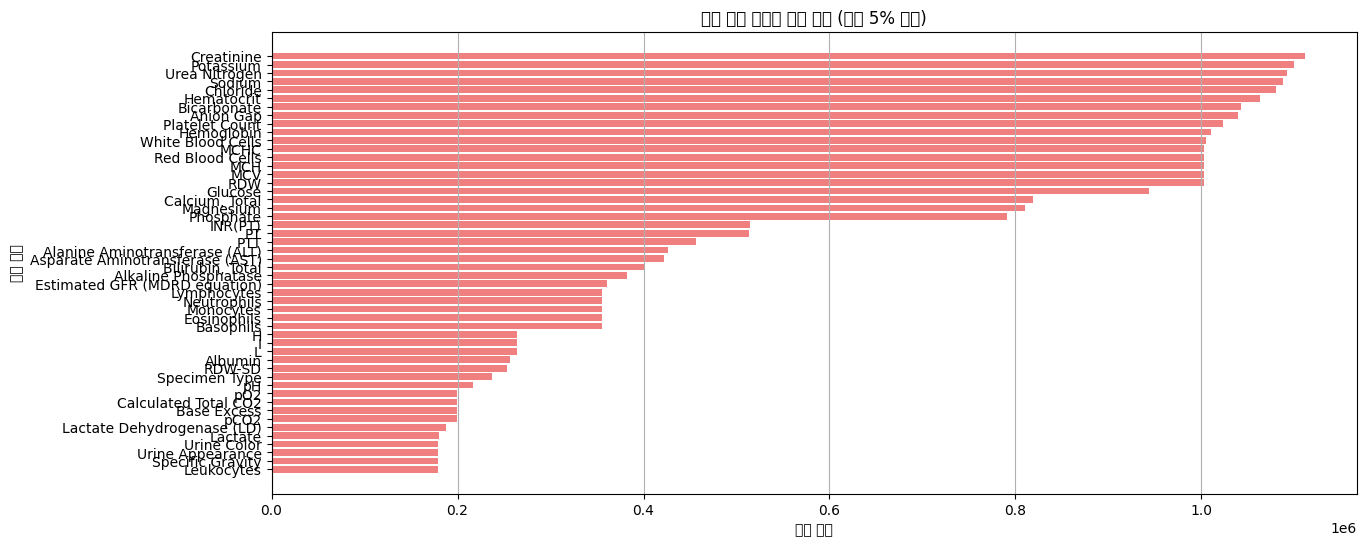

In [ ]:
# 선정된 주요 검사 항목만 필터링
important_tests = aki_labevents[aki_labevents['itemid'].isin(important_itemids['itemid'])]

# 각 검사 항목별 결과 통계 요약
important_stats = important_tests.groupby('itemid')['valuenum'].describe().reset_index()

# 검사 항목 정보 결합
important_stats = important_stats.merge(lab_items[['itemid', 'label']], on='itemid', how='left')

# 주요 검사 항목 결과 통계 요약 출력
print("주요 검사 항목별 결과 통계 요약:")
print(important_stats[['label', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# 주요 검사 항목별 수행 횟수 그래프
plt.figure(figsize=(14, 6))
plt.barh(important_itemids['label'], important_itemids['count'], color='lightcoral')
plt.xlabel('수행 횟수')
plt.ylabel('검사 항목')
plt.title('주요 검사 항목별 수행 횟수 (상위 5% 기준)')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()


Creatinine (50912):

- 평균 (mean): 1.80 mg/dL (정상 범위: 0.6 - 1.2 mg/dL)
- 표준편차 (std): 1.79
- 최소 (min): 0.0
- 1사분위수 (25%): 0.9
- 중앙값 (50%): 1.3
- 3사분위수 (75%): 2.0
- 최대 (max): 736.0

-> 신장 기능 평가를 위한 중요한 지표로, 정상 수치를 초과하면 신장 기능 저하 또는 급성 신부전이 의심됩니다.

Potassium (50971):

- 평균 (mean): 4.24 mEq/L (정상 범위: 3.5 - 5.0 mEq/L)
- 표준편차 (std): 0.66
- 최소 (min): 0.7
- 1사분위수 (25%): 3.8
- 중앙값 (50%): 4.2
- 3사분위수 (75%): 4.6
- 최대 (max): 14.1

-> 칼륨 수치가 증가하면 고칼륨혈증, 감소하면 저칼륨혈증으로 심장 및 신경계 기능에 문제가 생길 수 있습니다.

### 3. 한 환자 당 피 검사를 몇 번 했는지 통계

In [ ]:
# 각 환자의 검사 횟수 집계
patient_test_counts = aki_labevents.groupby('subject_id').size().reset_index(name='test_count')

# 상위 5명 환자의 검사 횟수 확인
print("환자별 검사 횟수 (상위 5명):")
print(patient_test_counts.head())

# 전체 통계 요약
print("\n전체 환자의 검사 횟수 통계 요약:")
print(patient_test_counts['test_count'].describe())

환자별 검사 횟수 (상위 5명):
   subject_id  test_count
0    10000690        1036
1    10000764         175
2    10000980        2876
3    10001338        1216
4    10001877         205

전체 환자의 검사 횟수 통계 요약:
count    20022.000000
mean      1843.361303
std       2613.894053
min         28.000000
25%        436.000000
50%        983.000000
75%       2143.000000
max      44152.000000
Name: test_count, dtype: float64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

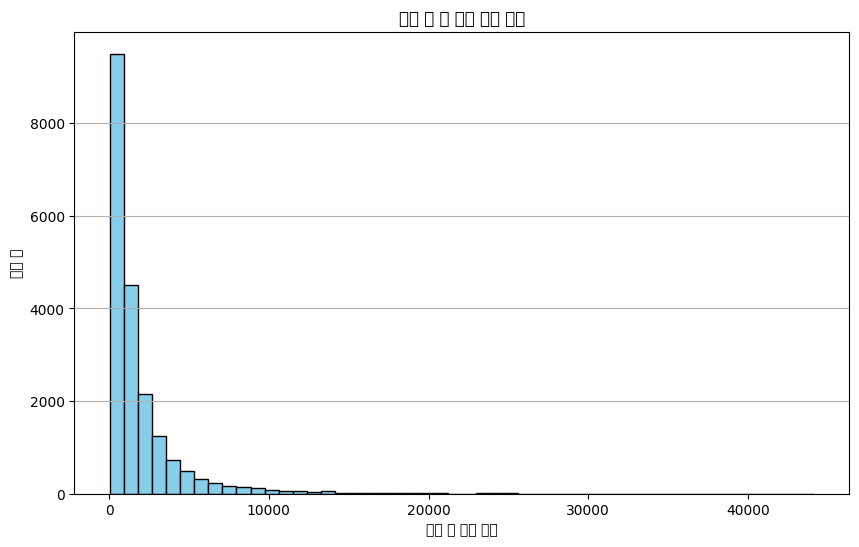

In [ ]:
import matplotlib.pyplot as plt

# 환자별 검사 횟수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(patient_test_counts['test_count'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('환자 당 검사 횟수')
plt.ylabel('환자 수')
plt.title('환자 당 피 검사 횟수 분포')
plt.grid(axis='y')
plt.show()


In [ ]:
import pandas as pd

# 피 검사로 분류된 주요 검사 항목 ID
blood_test_item_ids = [
    50912,  # Creatinine
    50971,  # Potassium
    51006,  # Urea Nitrogen
    50983,  # Sodium
    50902,  # Chloride
    51221,  # Hematocrit
    50882,  # Bicarbonate
    50868,  # Anion Gap
    51265,  # Platelet Count
    51222,  # Hemoglobin
    51301,  # White Blood Cells
    51279,  # Red Blood Cells
    51249,  # MCHC
    51248,  # MCH
    51250,  # MCV
    51277,  # RDW
    50931,  # Glucose
    50893,  # Calcium, Total
    50960,  # Magnesium
    50970,  # Phosphate
    50885,  # Bilirubin, Total
    50862,  # Albumin
    51244,  # Lymphocytes
    51256,  # Neutrophils
    51254,  # Monocytes
    51200,  # Eosinophils
    51146   # Basophils
]

# 피 검사 항목만 필터링
blood_tests = aki_labevents[aki_labevents['itemid'].isin(blood_test_item_ids)]

# 각 환자의 피 검사 횟수 집계
patient_blood_test_counts = blood_tests.groupby('subject_id').size().reset_index(name='blood_test_count')

# 상위 5명 환자의 피 검사 횟수 확인
print("환자별 피 검사 횟수 (상위 5명):")
print(patient_blood_test_counts.head())

# 전체 피 검사 통계 요약
print("\n전체 환자의 피 검사 횟수 통계 요약:")
print(patient_blood_test_counts['blood_test_count'].describe())


환자별 피 검사 횟수 (상위 5명):
   subject_id  blood_test_count
0    10000690               757
1    10000764               117
2    10000980              1840
3    10001338               672
4    10001877               117

전체 환자의 피 검사 횟수 통계 요약:
count    20022.000000
mean      1121.742683
std       1567.356500
min         19.000000
25%        268.000000
50%        606.000000
75%       1313.750000
max      27107.000000
Name: blood_test_count, dtype: float64


설명:

- count: 총 20,022명의 환자가 피 검사를 받은 기록이 있습니다.
- mean (평균): 환자 한 명당 평균적으로 약 1122번의 피 검사를 받았습니다.
- std (표준 편차): 피 검사 횟수의 표준 편차가 약 1567로, 이는 환자들 간의 피 검사 횟수 차이가 크게 분포되어 있음을 의미합니다.
- min (최소값): 가장 적게 피 검사를 받은 환자는 19번의 검사를 받았습니다.
- 25% (1사분위수): 하위 25%에 속하는 환자들은 268번 이하의 피 검사를 받았습니다.
- 50% (중앙값): 중앙값은 606으로, 전체 환자의 절반은 606번 이하, 나머지 절반은 606번 이상의 피 검사를 받았습니다.
- 75% (3사분위수): 상위 25%에 속하는 환자들은 1314번 이상의 피 검사를 받았습니다.
- max (최대값): 가장 많이 피 검사를 받은 환자는 27,107번의 검사를 받았습니다. 이 환자는 병원에서 매우 집중적으로 관리되었을 가능성이 있습니다.

즉,
- 대부분의 환자들이 수백 번에서 수천 번에 이르는 피 검사를 받았으며, 일부 환자들은 수만 번의 검사를 받기도 했습니다.
- 중앙값이 606인 것으로 보아, 절반 이상의 환자들이 600번 이하의 피 검사를 받은 반면, 일부 환자들은 매우 많은 횟수의 피 검사를 받은 것으로 보입니다.
- 피 검사 횟수의 편차가 커서, 환자별로 검사 횟수가 큰 차이가 있는 것으로 판단됩니다. 이는 환자 상태의 중증도나 병원에 머무른 기간 등의 요인에 따라 피 검사 횟수가 달라졌을 수 있음을 시사합니다.

추가해야 할 점
- 크레아티닌 한 환자 당 평균 검사 횟수 (전체 하루에 다수의 검사 다 포함 * 일자)
- 크레아티닌 한 환자 당 검사 일수 (1일 당) -> 하루에 다수의 검사의 평균값을 사용하기 때문에

- 랩 테스트 간격 (다음 검사까지의 간격)

- 성별과 나이 고려
- 주 진단 코드, 부 진단 코드
(AKI를 판명받은 환자의 주 진단 코드 -> 입원 중이다가 약물 과다, 너무 오래 누워 있을 경우 심장에 손상을 받아 부 진단으로 (합병증) AKI를 판명받았을 때를 고려)
=> department 분류 -> stage 1,2,3

### 크레아티닌 한 환자 당 평균 검사 횟수

In [ ]:
# 크레아티닌 검사 데이터 필터링 (itemid: 50912)
creatinine_tests = aki_labevents[aki_labevents['itemid'] == 50912]

# 날짜별 검사 횟수 계산
creatinine_tests['charttime'] = pd.to_datetime(creatinine_tests['charttime'])
creatinine_tests['date'] = creatinine_tests['charttime'].dt.date

# 환자-날짜별 검사 횟수 계산
daily_test_counts = creatinine_tests.groupby(['subject_id', 'date']).size().reset_index(name='daily_count')

# 환자별 전체 검사 횟수 계산
total_test_counts = daily_test_counts.groupby('subject_id')['daily_count'].sum().reset_index(name='total_count')

# 환자별 검사 일수 계산
test_days = daily_test_counts.groupby('subject_id')['date'].nunique().reset_index(name='test_days')

# 전체 검사 횟수와 검사 일수를 결합하여 환자별 평균 검사 횟수 계산
mean_test_counts = total_test_counts.merge(test_days, on='subject_id')
mean_test_counts['mean_daily_count'] = mean_test_counts['total_count'] / mean_test_counts['test_days']

# 전체 환자 데이터 결과 확인
print(f"전체 환자 수: {len(mean_test_counts)}")
print("크레아티닌 검사 환자 당 평균 검사 횟수 (전체 환자 기준):")
print(mean_test_counts.head())


<ipython-input-28-ec1962995fd3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creatinine_tests['charttime'] = pd.to_datetime(creatinine_tests['charttime'])
<ipython-input-28-ec1962995fd3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creatinine_tests['date'] = creatinine_tests['charttime'].dt.date


전체 환자 수: 20022
크레아티닌 검사 환자 당 평균 검사 횟수 (전체 환자 기준):
   subject_id  total_count  test_days  mean_daily_count
0    10000690           40         37          1.081081
1    10000764            6          6          1.000000
2    10000980           94         86          1.093023
3    10001338           32         32          1.000000
4    10001877            8          8          1.000000


In [ ]:
# 전체 환자에 대한 요약 통계 제공
mean_daily_summary = mean_test_counts['mean_daily_count'].describe()

print("전체 환자의 크레아티닌 검사 평균 횟수 통계 요약:")
print(mean_daily_summary)

# 크레아티닌 검사 평균 횟수가 높은 상위 10명 출력
print("\n크레아티닌 검사 평균 횟수 상위 10명:")
print(mean_test_counts.sort_values(by='mean_daily_count', ascending=False).head(10))

# 크레아티닌 검사 평균 횟수가 낮은 하위 10명 출력 (단, 검사를 받은 환자 중)
print("\n크레아티닌 검사 평균 횟수 하위 10명:")
print(mean_test_counts.sort_values(by='mean_daily_count', ascending=True).head(10))


전체 환자의 크레아티닌 검사 평균 횟수 통계 요약:
count    20022.000000
mean         1.237601
std          0.310692
min          1.000000
25%          1.055556
50%          1.142857
75%          1.302831
max          7.000000
Name: mean_daily_count, dtype: float64

크레아티닌 검사 평균 횟수 상위 10명:
       subject_id  total_count  test_days  mean_daily_count
18573    19272121            7          1          7.000000
11109    15543664           26          5          5.200000
12960    16467939            5          1          5.000000
841      10422501            9          2          4.500000
8827     14428323            9          2          4.500000
2901     11431214           35          8          4.375000
2853     11407769           17          4          4.250000
16413    18194653           46         11          4.181818
12248    16099220           49         12          4.083333
18589    19277968            8          2          4.000000

크레아티닌 검사 평균 횟수 하위 10명:
       subject_id  total_count  test_days  mean_

- total_count: 해당 환자가 크레아티닌 검사를 받은 전체 횟수
- test_days: 해당 환자가 크레아티닌 검사를 받은 날짜의 수 (하루에 여러 번 검사를 받더라도, 그날은 하나의 test_day로 계산됨)
- mean_daily_count: total_count를 test_days로 나누어 계산한 값으로, 하루 동안 몇 번의 검사를 받았는지 평균적으로 보여준다.

### 크레아티닌 한 환자 당 검사 일수 (1일 당) -> 하루에 다수의 검사의 평균값을 사용하기 때문에

In [ ]:
# 검사 일수만 추출
test_days = creatinine_tests.groupby('subject_id')['date'].nunique().reset_index(name='test_days')

# 전체 환자 데이터 결과 확인
print(f"전체 환자 수: {len(test_days)}")
print("크레아티닌 검사 환자 당 검사 일수 (전체 환자 기준):")
print(test_days.head())

전체 환자 수: 20022
크레아티닌 검사 환자 당 검사 일수 (전체 환자 기준):
   subject_id  test_days
0    10000690         37
1    10000764          6
2    10000980         86
3    10001338         32
4    10001877          8


In [ ]:
# 전체 환자에 대한 검사 일수 통계 요약
test_days_summary = test_days['test_days'].describe()

print("전체 환자의 크레아티닌 검사 일수 통계 요약:")
print(test_days_summary)


전체 환자의 크레아티닌 검사 일수 통계 요약:
count    20022.000000
mean        46.914094
std         62.776280
min          1.000000
25%         11.000000
50%         26.000000
75%         57.000000
max       1009.000000
Name: test_days, dtype: float64


In [ ]:
# test_days 기준으로 내림차순 정렬하여 상위 10명 추출
top_10_test_days = test_days.sort_values(by='test_days', ascending=False).head(10)

# 결과 확인
print("크레아티닌 검사 일수가 가장 많은 상위 10명:")
print(top_10_test_days)

크레아티닌 검사 일수가 가장 많은 상위 10명:
       subject_id  test_days
5004     12468016       1009
15455    17716210        837
6456     13198542        819
1837     10913302        772
6376     13162333        702
4656     12294892        678
6638     13297743        657
1153     10577647        643
13692    16846280        640
4373     12151259        635


- 크레아티닌 환자의 상위 10명의 환자는 크레아티닌 검사를 매우 빈번하게 받았으며, test_days 값이 매우 높다.
- 평균 검사 일수는 46.91일

### 랩 테스트 간격 (다음 검사까지의 간격)

In [ ]:
# 환자별 검사 시점 간격 계산
creatinine_tests = creatinine_tests.sort_values(by=['subject_id', 'charttime'])
creatinine_tests['next_test_diff'] = creatinine_tests.groupby('subject_id')['charttime'].diff().dt.total_seconds() / 3600  # 시간 단위로 변환

# 검사 간격 통계 계산
test_intervals = creatinine_tests.groupby('subject_id')['next_test_diff'].mean().reset_index(name='mean_test_interval')

# 결과 확인
print("환자별 평균 검사 간격 (시간 단위):")
print(test_intervals.head())

환자별 평균 검사 간격 (시간 단위):
   subject_id  mean_test_interval
0    10000690          555.777778
1    10000764           21.443333
2    10000980          745.737455
3    10001338         3308.932796
4    10001877         1888.621429


In [ ]:
# 전체 환자에 대한 평균 검사 간격 요약 통계
mean_interval_summary = test_intervals['mean_test_interval'].describe()

print("전체 환자의 평균 검사 간격 통계 요약 (시간 단위):")
print(mean_interval_summary)

전체 환자의 평균 검사 간격 통계 요약 (시간 단위):
count    19984.000000
mean       856.872037
std       1548.941066
min          0.266667
25%         58.229167
50%        402.528524
75%       1032.384417
max      57980.583333
Name: mean_test_interval, dtype: float64


In [ ]:
# 평균 검사 간격이 짧은 상위 10명
shortest_intervals = test_intervals.sort_values(by='mean_test_interval').head(10)
print("평균 검사 간격이 짧은 상위 10명:")
print(shortest_intervals)

# 평균 검사 간격이 긴 상위 10명
longest_intervals = test_intervals.sort_values(by='mean_test_interval', ascending=False).head(10)
print("평균 검사 간격이 긴 상위 10명:")
print(longest_intervals)

평균 검사 간격이 짧은 상위 10명:
       subject_id  mean_test_interval
6252     13101851            0.266667
5043     12487892            1.416667
18573    19272121            1.441667
12324    16137431            1.966667
3603     11788649            2.450000
16623    18299586            2.466667
4507     12222697            2.494444
11178    15579619            2.616667
791      10393214            2.650000
13538    16770442            2.769048
평균 검사 간격이 긴 상위 10명:
       subject_id  mean_test_interval
11439    15693752        57980.583333
13072    16531665        37481.716667
12536    16247445        31206.100000
4550     12245882        26302.138889
12064    16014846        24989.391667
11736    15848356        22451.462500
13859    16924638        21897.750000
11357    15657457        21698.322222
14236    17115910        20654.677778
1334     10675949        19833.208333


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

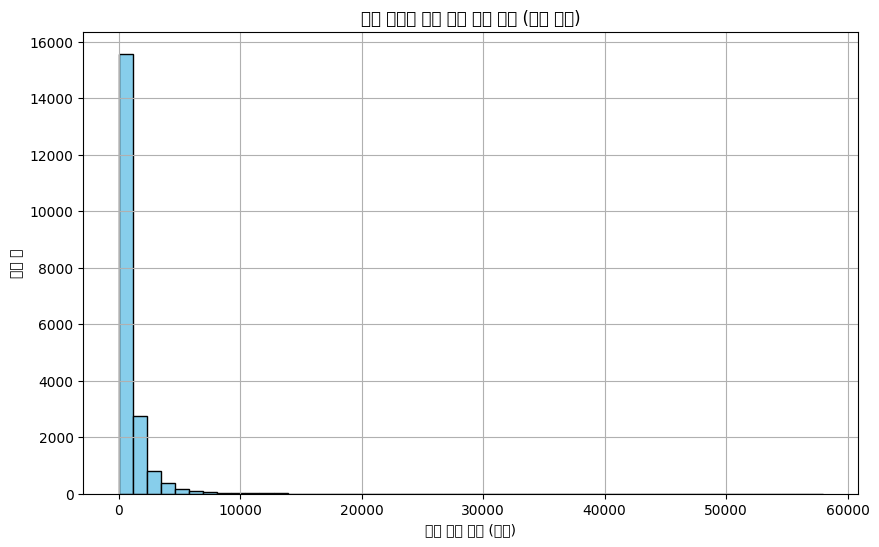

In [ ]:
import matplotlib.pyplot as plt

# 검사 간격의 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(test_intervals['mean_test_interval'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('전체 환자의 평균 검사 간격 분포 (시간 단위)')
plt.xlabel('평균 검사 간격 (시간)')
plt.ylabel('환자 수')
plt.grid(True)
plt.show()


### 성별과 나이 고려 (AKI 환자 중 크레아티닌 검사를 받은 환자들에 대한 것)

In [ ]:
import pandas as pd

# 데이터 파일 경로 설정
labevents_path = f'{path}/hosp/labevents.csv.gz'
patients_path = f'{path}/hosp/patients.csv.gz'

# RAM 절약을 위해 청크 사이즈를 설정합니다.
chunk_size = 1000000  # 100만 행 단위로 청크를 나눔

# AKI 환자의 labevents 데이터를 저장할 리스트 초기화
filtered_labevents = []

# 2. 청크 단위로 labevents 파일 읽기
for chunk in pd.read_csv(labevents_path, compression='gzip', chunksize=chunk_size):
    # 크레아티닌 검사 데이터만 필터링 (itemid: 50912)
    creatinine_tests = chunk[chunk['itemid'] == 50912]

    # AKI 환자 데이터 필터링
    filtered_chunk = creatinine_tests[creatinine_tests['subject_id'].isin(aki_patient_ids)]

    # 필터링된 청크를 리스트에 추가
    filtered_labevents.append(filtered_chunk)

    # 처리된 청크 수 확인
    print(f"청크 처리 완료, 현재 누적 행 수: {sum([len(c) for c in filtered_labevents])}")

# 3. 필터링된 모든 청크를 하나의 데이터프레임으로 병합
aki_labevents = pd.concat(filtered_labevents, ignore_index=True)

# 4. 병합된 데이터 확인
print("필터링된 AKI 환자의 크레아티닌 검사 데이터 샘플:")
print(aki_labevents.head())

# 병합된 데이터의 정보 확인
print("\naki_labevents 데이터프레임 정보:")
print(aki_labevents.info())

# 5. 필요한 경우, 환자 데이터 병합
patients = pd.read_csv(patients_path)
aki_labevents = aki_labevents.merge(patients[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')

# 병합된 데이터 확인
print("\n환자 정보가 포함된 AKI 환자의 크레아티닌 검사 데이터 샘플:")
print(aki_labevents.head())


청크 처리 완료, 현재 누적 행 수: 7686
청크 처리 완료, 현재 누적 행 수: 14190
청크 처리 완료, 현재 누적 행 수: 20418
청크 처리 완료, 현재 누적 행 수: 26768
청크 처리 완료, 현재 누적 행 수: 34321
청크 처리 완료, 현재 누적 행 수: 41584
청크 처리 완료, 현재 누적 행 수: 48272
청크 처리 완료, 현재 누적 행 수: 55366
청크 처리 완료, 현재 누적 행 수: 62388
청크 처리 완료, 현재 누적 행 수: 69191
청크 처리 완료, 현재 누적 행 수: 76221
청크 처리 완료, 현재 누적 행 수: 83033
청크 처리 완료, 현재 누적 행 수: 89097
청크 처리 완료, 현재 누적 행 수: 97287
청크 처리 완료, 현재 누적 행 수: 105192
청크 처리 완료, 현재 누적 행 수: 111807
청크 처리 완료, 현재 누적 행 수: 119219
청크 처리 완료, 현재 누적 행 수: 126655
청크 처리 완료, 현재 누적 행 수: 133963
청크 처리 완료, 현재 누적 행 수: 140702
청크 처리 완료, 현재 누적 행 수: 147553
청크 처리 완료, 현재 누적 행 수: 153140
청크 처리 완료, 현재 누적 행 수: 158532
청크 처리 완료, 현재 누적 행 수: 166117
청크 처리 완료, 현재 누적 행 수: 172661
청크 처리 완료, 현재 누적 행 수: 179849
청크 처리 완료, 현재 누적 행 수: 186436
청크 처리 완료, 현재 누적 행 수: 192347
청크 처리 완료, 현재 누적 행 수: 200014
청크 처리 완료, 현재 누적 행 수: 208879
청크 처리 완료, 현재 누적 행 수: 215050
청크 처리 완료, 현재 누적 행 수: 220485
청크 처리 완료, 현재 누적 행 수: 226969
청크 처리 완료, 현재 누적 행 수: 234400
청크 처리 완료, 현재 누적 행 수: 240918
청크 처리 완료, 현재 누적 행 수: 248361
청크 처리 완

In [ ]:
# 1. 검사 시점 간격 계산 (시간 단위)
aki_labevents['charttime'] = pd.to_datetime(aki_labevents['charttime'])  # 시간 형식 변환
aki_labevents = aki_labevents.sort_values(by=['subject_id', 'charttime'])  # subject_id와 charttime을 기준으로 정렬
aki_labevents['next_test_diff'] = aki_labevents.groupby('subject_id')['charttime'].diff().dt.total_seconds() / 3600  # 시간 차이를 시간 단위로 계산

# 2. 나이대 그룹화 추가
aki_labevents['age_group'] = (aki_labevents['anchor_age'] // 10) * 10  # 10대 단위로 나이대 그룹화

# 3. 성별 및 나이대별 평균 검사 간격 계산
gender_age_group_mean = aki_labevents.groupby(['gender', 'age_group'])['next_test_diff'].mean().reset_index()
gender_age_group_mean.columns = ['gender', 'age_group', 'mean_test_interval']

# 4. 성별 및 나이대별 전체 검사 간격 통계
gender_age_group_summary = aki_labevents.groupby(['gender', 'age_group'])['next_test_diff'].describe()

# 결과 확인
print("성별 및 나이대별 평균 검사 간격:")
print(gender_age_group_mean)

print("\n성별 및 나이대별 전체 검사 간격 통계 요약:")
print(gender_age_group_summary)


성별 및 나이대별 평균 검사 간격:
   gender  age_group  mean_test_interval
0       F         10          723.651647
1       F         20          527.582158
2       F         30          563.555429
3       F         40          535.403920
4       F         50          571.063331
5       F         60          548.779457
6       F         70          633.391437
7       F         80          697.150148
8       F         90          731.394503
9       M         10         1365.367371
10      M         20          527.862812
11      M         30          479.699446
12      M         40          562.349121
13      M         50          525.294918
14      M         60          538.614929
15      M         70          603.821804
16      M         80          599.611449
17      M         90          523.867404

성별 및 나이대별 전체 검사 간격 통계 요약:
                     count         mean          std       min        25%  \
gender age_group                                                            
F      10           

여성(F)의 평균 검사 간격:
- 10대 여성은 평균 723.65시간(약 30일) 간격으로 검사를 받고 있습니다.
- 20대부터 80대까지 평균 검사 간격은 527.58시간에서 697.15시간(약 22일에서 29일) 사이로 비교적 일정하게 분포되어 있습니다.
- 90대에서는 평균 검사 간격이 다시 증가하여 731.39시간(약 30일)로 나타났습니다.

남성(M)의 평균 검사 간격:
- 10대 남성의 평균 검사 간격은 1365.37시간(약 57일)로, 다른 나이대와 비교했을 때 현저히 높습니다.
- 20대부터 80대까지 평균 검사 간격은 479.70시간에서 603.82시간(약 20일에서 25일)로 비교적 일정하게 나타나며, 여성의 간격과 큰 차이는 없습니다.
- 90대 남성의 평균 검사 간격은 523.87시간(약 22일)로, 다른 나이대와 비슷하게 유지되고 있습니다.

- 나이대가 증가할수록 평균 검사 간격이 조금씩 증가하지만, 50% 중앙값이 대부분 24시간으로 비슷합니다.
- 10대 남성 환자들의 검사 간격 변동성이 크다는 점을 주목할 필요가 있으며, 이들에 대한 추가 분석이 필요할 수 있습니다.
- 전반적으로 성별과 나이대에 따라 검사 간격이 크게 다르지는 않지만, 특정 환자들의 경우 검사 간격이 매우 불규칙하거나 긴 경우가 있음을 확인할 수 있습니다.

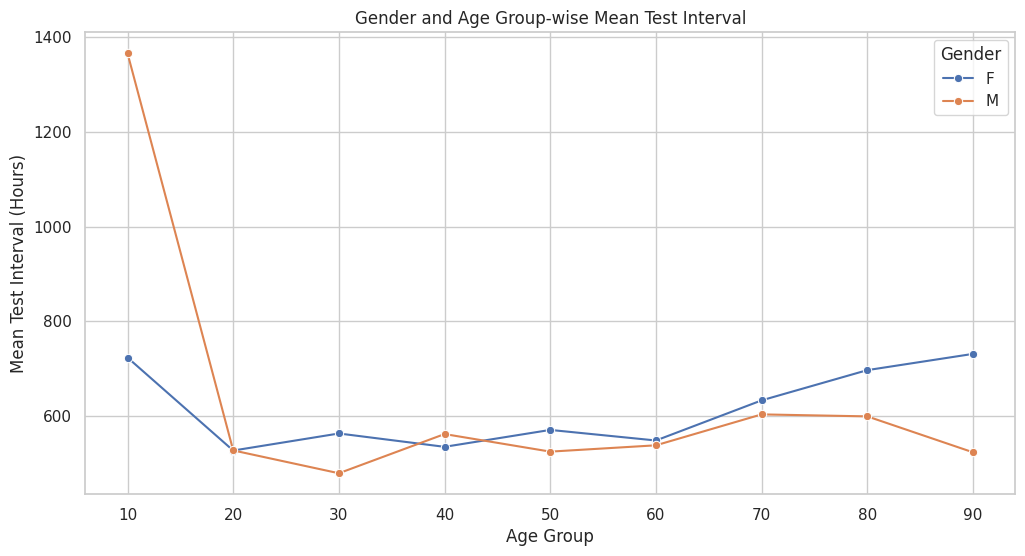

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 라인플롯 생성
plt.figure(figsize=(12, 6))
sns.lineplot(data=gender_age_group_mean, x='age_group', y='mean_test_interval', hue='gender', marker='o')

# 그래프 제목 및 축 레이블 설정
plt.title('Gender and Age Group-wise Mean Test Interval')
plt.xlabel('Age Group')
plt.ylabel('Mean Test Interval (Hours)')
plt.legend(title='Gender')
plt.xticks(gender_age_group_mean['age_group'].unique())  # 나이대가 순서대로 나오도록 설정

# 그래프 표시
plt.show()


그래프는 성별과 나이대별 평균 검사 간격을 나타냅니다.
- **남성(M)**의 경우, 10대의 평균 검사 간격이 매우 길었으며, 이후 나이대에서 급격히 감소하여 일정한 패턴을 보이고 있습니다.
- **여성(F)**은 10대에서 평균 검사 간격이 남성보다 짧았으며, 전반적으로 남성보다 작은 변동성을 보입니다.
- 60대 이후 여성의 평균 검사 간격이 증가하는 경향을 보입니다.

특이사항:
- 10대 남성의 평균 검사 간격이 비정상적으로 길어 다른 나이대와 큰 차이가 있습니다. 이는 데이터의 특이치일 가능성이 높습니다.
전반적으로 남성보다 여성이 검사 간격이 긴 경향이 있습니다.

## 성별 및 나이대별 AKI 환자 수 통계

In [ ]:
# 나이대 그룹화 (10대 단위)
aki_labevents['age_group'] = (aki_labevents['anchor_age'] // 10) * 10

# 성별 및 나이대별 환자 수 계산
gender_age_count = aki_labevents.groupby(['gender', 'age_group'])['subject_id'].nunique().reset_index()
gender_age_count.columns = ['gender', 'age_group', 'patient_count']

# 성별 및 나이대별 환자 수 출력
print("성별 및 나이대별 환자 수:")
print(gender_age_count)

# 전체 성별 환자 수 계산
gender_count = aki_labevents.groupby('gender')['subject_id'].nunique().reset_index()
gender_count.columns = ['gender', 'patient_count']
print("\n성별별 전체 환자 수:")
print(gender_count)


성별 및 나이대별 환자 수:
   gender  age_group  patient_count
0       F         10             12
1       F         20            166
2       F         30            244
3       F         40            584
4       F         50           1134
5       F         60           1634
6       F         70           1896
7       F         80           2165
8       F         90            912
9       M         10             14
10      M         20            265
11      M         30            427
12      M         40           1010
13      M         50           1954
14      M         60           2544
15      M         70           2374
16      M         80           2135
17      M         90            552

성별별 전체 환자 수:
  gender  patient_count
0      F           8747
1      M          11275


### 주 진단 코드, 부 진단 코드 (AKI를 판명받은 환자의 주 진단 코드 -> 입원 중이다가 약물 과다, 너무 오래 누워 있을 경우 심장에 손상을 받아 부 진단으로 (합병증) AKI를 판명받았을 때를 고려) => department 분류 -> stage 1,2,3

In [ ]:
drgcodes_path = f'{path}/hosp/drgcodes.csv.gz'
drgcodes = pd.read_csv(drgcodes_path)

In [ ]:
# 주 진단과 부 진단 구분
primary_diagnosis = diagnoses_icd[(diagnoses_icd['seq_num'] == 1) & (diagnoses_icd['subject_id'].isin(aki_patient_ids))]
secondary_diagnosis = diagnoses_icd[(diagnoses_icd['seq_num'] > 1) & (diagnoses_icd['subject_id'].isin(aki_patient_ids))]

# 주 진단 코드 통계
primary_counts = primary_diagnosis['icd_code'].value_counts().reset_index()
primary_counts.columns = ['icd_code', 'count']

# 부 진단 코드 통계
secondary_counts = secondary_diagnosis['icd_code'].value_counts().reset_index()
secondary_counts.columns = ['icd_code', 'count']

# DRG 코드와 연결하여 분석
drg_aki = drgcodes[drgcodes['subject_id'].isin(aki_patient_ids)]
drg_primary = drg_aki[drg_aki['drg_type'] == 'APR']

# DRG 코드별 주 진단 코드 통계
drg_primary_counts = drg_primary.groupby(['drg_code', 'description'])['subject_id'].nunique().reset_index()
drg_primary_counts.columns = ['drg_code', 'description', 'patient_count']

# 결과 확인
print("주 진단 코드별 환자 수:")
print(primary_counts.head())

print("\n부 진단 코드별 환자 수:")
print(secondary_counts.head())

print("\nAKI 환자의 DRG 코드별 환자 수:")
print(drg_primary_counts.head())


주 진단 코드별 환자 수:
  icd_code  count
0     5849   3532
1     0389   2126
2      486   1808
3    42833   1743
4     5990   1580

부 진단 코드별 환자 수:
  icd_code  count
0     4019  33537
1     2724  27222
2     5849  25604
3     4280  23617
4    25000  19288

AKI 환자의 DRG 코드별 환자 수:
   drg_code                                        description  patient_count
0         1      LIVER TRANSPLANT AND/OR INTESTINAL TRANSPLANT            183
1         4  TRACHEOSTOMY WITH MV >96 HOURS WITH EXTENSIVE ...            234
2         5  TRACHEOSTOMY WITH MV >96 HOURS WITHOUT EXTENSI...            217
3         6                                PANCREAS TRANSPLANT             36
4         8  AUTOLOGOUS BONE MARROW TRANSPLANT OR T-CELL IM...              3


주 진단 코드(primary diagnosis)는 입원 시 처음 기록된 주요 진단을 나타냅니다.

- icd_code 5849는 급성 신장 손상(AKI)에 해당하며, 이는 3532명의 환자에게 주 진단으로 기록되었습니다.

- 그 외의 주요 진단으로는 패혈증(0389)과 폐렴(486)이 있습니다.

- 부 진단 코드(secondary diagnosis)는 입원 중 발생한 추가적인 문제나 합병증을 나타냅니다.

- icd_code 4019(고혈압)이 가장 많이 기록된 부 진단 코드이며, 33537명의 환자에게 해당됩니다.

- icd_code 5849도 부 진단으로 기록되었는데, 이는 주 진단 이외에도 입원 중 AKI가 발생했음을 의미합니다.

- DRG 코드(drg_code)는 특정 입원 에피소드에 대해 진단 관련 그룹을 나타내며, 환자의 상태와 관련된 그룹화된 정보를 제공합니다.
- drg_code 1은 간 또는 장기 이식 수술을 받은 환자에 해당하며, AKI를 진단받은 환자 중 183명이 이 그룹에 속합니다.
- drg_code 4와 5는 96시간 이상의 기계 호흡이 필요한 중증 환자 그룹을 나타내며, 각각 234명, 217명의 환자가 속합니다.
- 이를 통해 AKI 환자가 중증 질환이나 중재적 시술(예: 장기 이식, 기계 호흡 등)을 동반한 경우가 많음을 알 수 있습니다.